In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



Using TensorFlow backend.


In [2]:

path = 'input/'

EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
# TEST_DATA_FILE=f'{path}test.csv'

In [3]:


# configuring basic parameters

embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use


In [4]:

# Read in our data and replace missing values:

train = pd.read_csv(TRAIN_DATA_FILE)
# test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
# list_sentences_test = test["comment_text"].fillna("_na_").values



In [5]:
# Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))


In [6]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
# X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [9]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))




In [8]:
# Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector



In [15]:
# Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
# x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(x)

x = LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(x)

x = LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(x)

x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [16]:
# Now we're ready to fit out model! Use validation_split when not submitting.

model.fit(X_t, y, 
          batch_size=32, 
          epochs=10, 
          validation_split=0.2);



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 1107s 9ms/step - loss: 0.0775 - acc: 0.9749 - val_loss: 0.0522 - val_acc: 0.9811
Epoch 2/10
127656/127656 [==============================] - 1044s 8ms/step - loss: 0.0528 - acc: 0.9809 - val_loss: 0.0522 - val_acc: 0.9805
Epoch 3/10
127656/127656 [==============================] - 1048s 8ms/step - loss: 0.0490 - acc: 0.9820 - val_loss: 0.0495 - val_acc: 0.9821
Epoch 4/10
127656/127656 [==============================] - 1048s 8ms/step - loss: 0.0464 - acc: 0.9828 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 5/10
127656/127656 [==============================] - 1046s 8ms/step - loss: 0.0449 - acc: 0.9832 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 6/10
127656/127656 [==============================] - 1037s 8ms/step - loss: 0.0432 - acc: 0.9836 - val_loss: 0.

In [17]:
# And finally, get predictions for the test set and prepare a submission CSV:

# y_test = model.predict([X_te], batch_size=1024, verbose=1)
# sample_submission = pd.read_csv(f'{path}sample_submission.csv')
# sample_submission[list_classes] = y_test
# sample_submission.to_csv('submission.csv', index=False)


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
__________

In [19]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

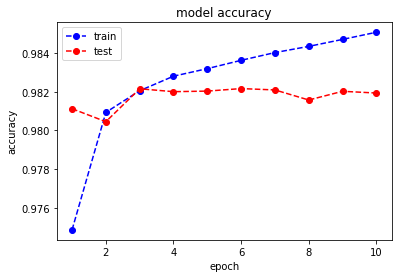

In [21]:
import matplotlib.pyplot as plt
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]

plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'test'], loc='upper left')
plt.show()

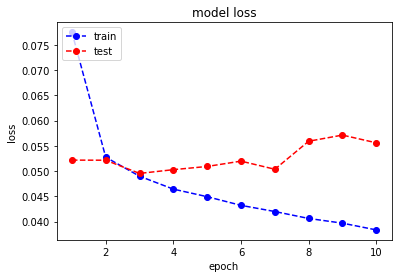

In [22]:
A = range(1,len(model.history.history['loss'])+1)
B = model.history.history['loss']
C = model.history.history['val_loss']
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
from keras.models import model_from_json
model_json = model.to_json()
with open("3LSTM_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("3LSTM_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
def sample_test(S1):
    v=tokenizer.texts_to_sequences([S1])
    v=pad_sequences(v,maxlen=maxlen)
    y=list(model.predict([v], batch_size=1024, verbose=1))
    for i in range(6):
        print(y[0][i], list_classes[i])

In [ ]:
S1 = input("Sentence: ")
sample_test(S1)

In [ ]:
S1 = input("Sentence: ")
sample_test(S1)


In [ ]:
S1 = input("Sentence: ")
sample_test(S1)


In [ ]:
S1 = input("Sentence: ")
sample_test(S1)


In [ ]:
S1 = input("Sentence: ")
sample_test(S1)

In [ ]:
S1 = input("Sentence: ")
sample_test(S1)